# Свёрточная нейронная сеть для распознавания рукописного текста

## Цель работы

Построить свёрточную нейронную сеть (CNN) для задачи распознавания рукописных символов.

## Ход работы

Распознавание почерка, или так называемая классификация рукописных документов, является сложной задачей из-за огромной вариативности индивидуальных стилей письма. Традиционный подход к решению этой проблемы заключается в извлечении языковых признаков, таких как кривизна различных букв, расстояние между буквами и т.д.

В данной работе для выявления этих особенностей будет использована сверточная нейронная сеть (CNN).

### Импортируем необходимые библиотеки

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '' # hides the GPU from tensorflow (for science)
import gzip
import tensorflow.keras
import matplotlib.pyplot as plt
import numpy as np
import random
import struct
import time

#List computing devices available to tensorflow:
from tensorflow.python.client import device_lib
device_list = device_lib.list_local_devices()
[x.name for x in device_list]

['/device:CPU:0']

### Загружаем датасет

В данной работе для обучения и тестирования использовался набор данных EMNIST, представляющий собой набор рукописных символов, полученных из специальной базы данных NIST 19 и преобразованных в формат изображения 28×28 пикселей - структуру набора данных, которая непосредственно соответствует набору данных MNIST. 

In [2]:
#List computing devices available to tensor-flow:
%matplotlib inline
random.seed(12345)
image_dir = '/content/drive/MyDrive/Colab Notebooks/data/gzip/'
labels = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz'
categories = len(labels)
batch_size = 1024
epochs = 10
model_path = '/content/drive/MyDrive/Colab Notebooks/models_EMNIST'

In [5]:
#Install EMIST library, import datasets of letters, Matplotlib
# !pip install emnist

In [6]:
from emnist import list_datasets
from emnist import extract_training_samples
from emnist import extract_test_samples
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
#Download dataset and it is 536 MB
list_datasets()

['balanced', 'byclass', 'bymerge', 'digits', 'letters', 'mnist']

In [8]:
#Download images of letters from training samples or test samples
#from emnist import extract_test_samples
raw_train_X, raw_train_y = extract_training_samples('byclass')
raw_train_X.shape

(697932, 28, 28)

In [9]:
raw_train_y.shape

(697932,)

In [10]:
np.unique(raw_train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], dtype=uint8)

In [11]:
raw_test_X, raw_test_y = extract_test_samples('byclass')
raw_test_X.shape

(116323, 28, 28)

In [12]:
raw_test_y.shape

(116323,)

Выведем случайное изображение, чтобы убедиться, что данные считаны корректно:

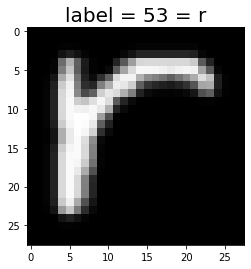

In [13]:
i = random.randint(0, raw_train_X.shape[0])
fig, ax = plt.subplots()
ax.clear()
ax.imshow(raw_train_X[i], cmap='gray')
title = 'label = %d = %s' % (raw_train_y[i], labels[raw_train_y[i]])
ax.set_title(title, fontsize=20)
plt.show()

### Предобработка данных

Предварительная обработка набора данных EMNIST включает нормализацию входных данных для обучения и тестирования, изменение формы входных данных для ввода в CNN и one-hot кодирование выходных данных (меток).

In [14]:
train_X = raw_train_X.astype('float32')
test_X = raw_test_X.astype('float32')
train_X /= 255
test_X /= 255

In [15]:
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1)
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)

In [16]:
train_y = tensorflow.keras.utils.to_categorical(raw_train_y)
test_y = tensorflow.keras.utils.to_categorical(raw_test_y)

### Задаём модель нейронной сети

Для этой задачи мы построим сверточную нейронную сеть (CNN) в Keras с использованием бэкенда Tensorflow. Мы будем использовать стандартную CNN с несколькими слоями свертки и Maxpool, несколькими плотными слоями и финальным выходным слоем с активацией softmax. Между сверточным и плотным слоями использовалась активация RELU, а модель была оптимизирована с помощью оптимизатора Adam.

Входное изображение подается на слои CNN. Эти слои обучаются извлекать соответствующие признаки из изображения. Каждый слой состоит из трех операций. Во-первых, операция свертки, при которой к входному изображению применяется ядро фильтра размером 5×5 в первых двух слоях и 3×3 в последних трех слоях. Затем применяется нелинейная функция RELU. Наконец, слой объединения суммирует области изображения и выдает уменьшенную версию входного сигнала. Пока высота изображения уменьшается в 2 раза в каждом слое, добавляются карты признаков (каналы), так что выходная карта признаков (или последовательность) имеет размер 32×256.

In [17]:
import tensorflow
model = tensorflow.keras.models.Sequential()
model.add(tensorflow.keras.layers.Conv2D(32,
                kernel_size=(5, 5),
                strides=(2, 2),
                input_shape=(28, 28, 1),
                activation='relu'))
model.add(tensorflow.keras.layers.Conv2D(64,
                kernel_size=(3, 3),
                activation='relu'))
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tensorflow.keras.layers.Dropout(0.25))
model.add(tensorflow.keras.layers.Flatten())
model.add(tensorflow.keras.layers.Dense(128, activation='relu'))
model.add(tensorflow.keras.layers.Dropout(0.25))
model.add(tensorflow.keras.layers.Dense(categories, activation='softmax'))

In [18]:
model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

### Обучаем модель

In [1]:
# t1 = time.time()
# fit = model.fit(train_X, train_y, batch_size=batch_size, epochs=30, verbose=1, validation_data=(test_X, test_y))
# t2 = time.time()
# print('Elapsed time: %ds' % (t2 - t1))
# model.save('/content/drive/MyDrive/Colab Notebooks/models_EMNIST/emnist_letters_30epochs.h5')

In [21]:
model = tensorflow.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/models_EMNIST/emnist_letters_30epochs.h5')

### Тестирование модели

In [22]:
results = model.evaluate(test_X, test_y)

3636/3636 [==============================] - 26s 7ms/step - loss: 0.3420 - accuracy: 0.8726


In [23]:
print(results[0]*100, results[1]*100)

34.19691622257233 87.25789189338684


## Выводы

Точность распознавания текста составила 87,2 % при потерях 34,2 %.

Распознавание рукописного текста с помощью глубокого обучения - очень мощная техника по нескольким причинам:

* Оно автоматически идентифицирует глубокие мощные признаки
* Наш подход, заключающийся в подаче случайных участков, делает модель независимой от текста
* Высокая точность предсказания позволяет использовать ее в практических приложениях